# Facial Expression Recognition with Transfer Learning

This program performs **facial expression recognition** using **transfer learning** with a pre-trained **ResNet-18** model. The dataset consists of images categorized into 8 different facial expressions:
1. **Anger**
2. **Contempt**
3. **Disgust**
4. **Fear**
5. **Happy**
6. **Neutral**
7. **Sad**
8. **Surprised**

## Steps in the Program:
1. **Import Libraries and Setup**: Import necessary Python libraries and set up the device (CPU or GPU) for computations.
2. **Dataset Preparation**:
   - Load and preprocess image data using a custom PyTorch `Dataset`.
   - Normalize and resize the images.
   - Use `DataLoader` for batch processing.
3. **Load Pre-trained Model**:
   - Load **ResNet-18** from `torchvision`.
   - Modify the final fully connected layer to adapt to the 8-class classification task.
4. **Model Compilation**:
   - Define loss function (`NLLLoss`) and optimizer (`Adam`).
5. **Training and Validation**:
   - Train the model while tracking performance metrics (accuracy and loss).
   - Evaluate the model on the validation dataset.
6. **Visualization**:
   - Plot the accuracy and loss trends over the training epochs.

## Model Architecture:
- **Pre-trained Backbone**: ResNet-18 (trained on ImageNet) is used for feature extraction. Layers are frozen to prevent re-training on the current dataset.
- **Custom Fully Connected Layers**:
  - Linear layer with 256 hidden units.
  - ReLU activation function.
  - Dropout (50%) for regularization.
  - Final linear layer with 8 output units for classification into 8 facial expression categories.
  - LogSoftmax for output probability distribution.

## Expected Outcome:
The model should be able to classify facial expressions with reasonable accuracy. Transfer learning leverages pre-trained features, reducing the need for large datasets and extensive training time.


# Model Architecture: ResNet-18 with Custom Classification Head

The architecture of the model used is based on **ResNet-18**, a convolutional neural network pre-trained on the ImageNet dataset.

## 1. **Feature Extraction (Frozen Layers)**
- ResNet-18 backbone is used as-is for feature extraction.
- All convolutional and batch normalization layers are frozen (i.e., `requires_grad=False`).

### Summary of ResNet-18:
- **Input**: RGB image of size 224x224x3.
- **Convolutional Layers**:
  - Stack of residual blocks, each containing:
    - 2 convolutional layers with Batch Normalization and ReLU.
    - Skip connections for better gradient flow.
  - Divided into 4 stages, progressively reducing spatial dimensions:
    - Stage 1: 64 channels, output size 112x112.
    - Stage 2: 128 channels, output size 56x56.
    - Stage 3: 256 channels, output size 28x28.
    - Stage 4: 512 channels, output size 7x7.
- **Global Average Pooling**: Reduces feature maps to a 512-dimensional vector.

## 2. **Custom Classification Head**
- **Flattening**: Converts 512-dimensional vector into a 1D tensor.
- **Fully Connected Layers**:
  - **Layer 1**: Linear layer with 256 units and ReLU activation.
  - **Dropout**: 50% for regularization to prevent overfitting.
  - **Layer 2**: Linear layer with 8 output units (for 8 classes).
  - **LogSoftmax**: Outputs log probabilities for each class.

### Summary of Custom Layers:
- `Linear(512, 256) → ReLU → Dropout(0.5)`
- `Linear(256, 8) → LogSoftmax`

## Model Diagram:
1. **ResNet Backbone**:
   - Input: RGB image.
   - Output: 512-dimensional feature vector.
2. **Classification Head**:
   - Input: 512-dimensional feature vector.
   - Output: Log probabilities of 8 classes.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models, transforms

# Setup perangkat
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan perangkat: {device}")


Menggunakan perangkat: cuda


In [2]:

# Custom Dataset untuk ekspresi wajah
class FacialExpressionDataset(Dataset):
    def __init__(self, root_dir, phase='train', transform=None):
        self.root_dir = root_dir
        self.phase = phase
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_mapping = {
            "angry": 0,
            "disgust": 1,
            "fear": 2,
            "happy": 3,
            "neutral": 4,
            "sad": 5,
            "surprise": 6
        }
        self._prepare_dataset()

    def _prepare_dataset(self):
        dataset_folder = os.path.join(self.root_dir, self.phase)
        
        for label_name in os.listdir(dataset_folder):
            label_folder = os.path.join(dataset_folder, label_name)
            if os.path.isdir(label_folder):  # Pastikan itu folder
                for filename in os.listdir(label_folder):
                    if filename.endswith(".jpg"):  # Hanya file gambar yang digunakan
                        self.image_paths.append(os.path.join(label_folder, filename))
                        self.labels.append(self.label_mapping.get(label_name.lower(), -1))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformasi data
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize gambar
    transforms.ToTensor(),  # Konversi ke Tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalisasi sesuai ImageNet
                         [0.229, 0.224, 0.225])
])

# Path dataset
root_dir = './Dataset/images'

# Dataset untuk training dan validasi
train_dataset = FacialExpressionDataset(root_dir=root_dir, phase='train', transform=transform)
print(f"Total data untuk training: {len(train_dataset)}")

valid_dataset = FacialExpressionDataset(root_dir=root_dir, phase='validation', transform=transform)
print(f"Total data untuk validation: {len(valid_dataset)}")

Total data untuk training: 28821
Total data untuk validation: 7066


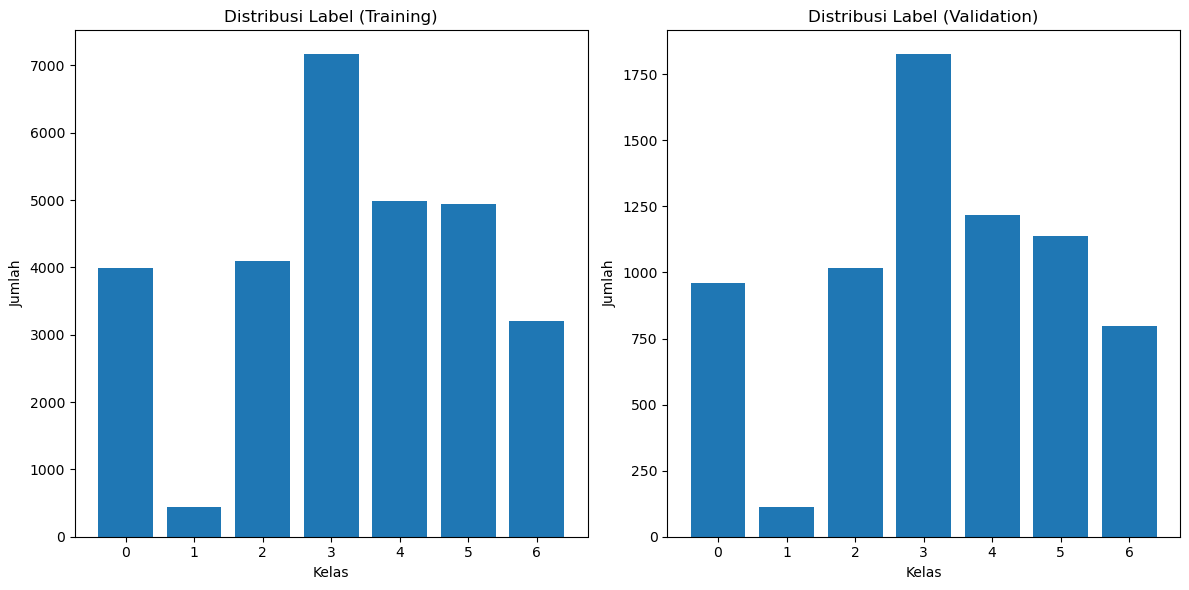

In [3]:
# Visualisasi distribusi label untuk training dataset
train_counter = Counter(train_dataset.labels)
valid_counter = Counter(valid_dataset.labels)

# Plot distribusi label
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Training data
ax1.bar(train_counter.keys(), train_counter.values())
ax1.set_title("Distribusi Label (Training)")
ax1.set_xlabel("Kelas")
ax1.set_ylabel("Jumlah")

# Validation data
ax2.bar(valid_counter.keys(), valid_counter.values())
ax2.set_title("Distribusi Label (Validation)")
ax2.set_xlabel("Kelas")
ax2.set_ylabel("Jumlah")

plt.tight_layout()
plt.show()

In [4]:
# Load model pre-trained ResNet-18
model_resnet = models.resnet18(pretrained=True)

# Freeze semua layer
for param in model_resnet.parameters():
    param.requires_grad = False

# Ganti fully connected layer terakhir
num_classes = 8  # Jumlah ekspresi
model_resnet.fc = nn.Sequential(
    nn.Linear(model_resnet.fc.in_features, 256),  # Layer tambahan
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes),  # Output untuk jumlah kelas
    nn.LogSoftmax(dim=1)  # LogSoftmax untuk klasifikasi
)

# Kirim model ke perangkat
model_resnet = model_resnet.to(device)
print(model_resnet)


C:\Users\gabri\anaconda3\envs\workenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gabri\anaconda3\envs\workenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# Loss function dan optimizer
criterion = nn.CrossEntropyLoss()  # Digunakan untuk klasifikasi multi-kelas
optimizer = optim.Adam(model_resnet.fc.parameters(), lr=0.005)

# Jumlah epoch
num_epochs = 25

# History training
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# Dataset dan DataLoader
train_loader = DataLoader(train_dataset, batch_size=54, shuffle=True)
validation_loader = DataLoader(valid_dataset, batch_size=54, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training phase
    model_resnet.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model_resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    # Validation phase
    model_resnet.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(validation_loader, desc="Validation"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_resnet(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.double() / len(validation_loader.dataset)
    valid_losses.append(val_epoch_loss)
    valid_accuracies.append(val_epoch_acc.item())

    print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

print("Training selesai!")

Epoch 1/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.76it/s]


Train Loss: 1.6762, Train Acc: 0.3175
Val Loss: 1.6532, Val Acc: 0.3136
Epoch 2/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.77it/s]


Train Loss: 1.6814, Train Acc: 0.3060
Val Loss: 1.5593, Val Acc: 0.4144
Epoch 3/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.80it/s]


Train Loss: 1.6570, Train Acc: 0.3278
Val Loss: 1.6189, Val Acc: 0.3520
Epoch 4/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.79it/s]


Train Loss: 1.6523, Train Acc: 0.3298
Val Loss: 1.5950, Val Acc: 0.3807
Epoch 5/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.79it/s]


Train Loss: 1.6615, Train Acc: 0.3307
Val Loss: 1.6092, Val Acc: 0.3861
Epoch 6/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.92it/s]


Train Loss: 1.6683, Train Acc: 0.3343
Val Loss: 1.5870, Val Acc: 0.4120
Epoch 7/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.88it/s]


Train Loss: 1.6638, Train Acc: 0.3353
Val Loss: 1.5636, Val Acc: 0.4157
Epoch 8/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.76it/s]


Train Loss: 1.6545, Train Acc: 0.3380
Val Loss: 1.5807, Val Acc: 0.3687
Epoch 9/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.94it/s]


Train Loss: 1.6389, Train Acc: 0.3452
Val Loss: 1.5478, Val Acc: 0.3960
Epoch 10/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.90it/s]


Train Loss: 1.6395, Train Acc: 0.3412
Val Loss: 1.5609, Val Acc: 0.4084
Epoch 11/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.93it/s]


Train Loss: 1.6425, Train Acc: 0.3432
Val Loss: 1.5462, Val Acc: 0.4138
Epoch 12/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.94it/s]


Train Loss: 1.6487, Train Acc: 0.3379
Val Loss: 1.5429, Val Acc: 0.4165
Epoch 13/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.87it/s]


Train Loss: 1.6302, Train Acc: 0.3455
Val Loss: 1.5498, Val Acc: 0.4084
Epoch 14/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.87it/s]


Train Loss: 1.6314, Train Acc: 0.3455
Val Loss: 1.5539, Val Acc: 0.4050
Epoch 15/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.86it/s]


Train Loss: 1.6339, Train Acc: 0.3443
Val Loss: 1.5261, Val Acc: 0.4142
Epoch 16/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.82it/s]


Train Loss: 1.6313, Train Acc: 0.3454
Val Loss: 1.5525, Val Acc: 0.3992
Epoch 17/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.78it/s]


Train Loss: 1.6261, Train Acc: 0.3462
Val Loss: 1.5337, Val Acc: 0.4274
Epoch 18/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.80it/s]


Train Loss: 1.6281, Train Acc: 0.3485
Val Loss: 1.5450, Val Acc: 0.4094
Epoch 19/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  8.05it/s]


Train Loss: 1.6278, Train Acc: 0.3462
Val Loss: 1.5401, Val Acc: 0.4161
Epoch 20/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  8.00it/s]


Train Loss: 1.6295, Train Acc: 0.3504
Val Loss: 1.5607, Val Acc: 0.4192
Epoch 21/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.95it/s]


Train Loss: 1.6231, Train Acc: 0.3485
Val Loss: 1.5350, Val Acc: 0.4291
Epoch 22/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.86it/s]


Train Loss: 1.6252, Train Acc: 0.3479
Val Loss: 1.5272, Val Acc: 0.4256
Epoch 23/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.88it/s]


Train Loss: 1.6237, Train Acc: 0.3490
Val Loss: 1.5765, Val Acc: 0.3834
Epoch 24/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.81it/s]


Train Loss: 1.6278, Train Acc: 0.3466
Val Loss: 1.5589, Val Acc: 0.4086
Epoch 25/25


Validation: 100%|██████████| 131/131 [00:16<00:00,  7.73it/s]

Train Loss: 1.6228, Train Acc: 0.3482
Val Loss: 1.5215, Val Acc: 0.4257
Training selesai!


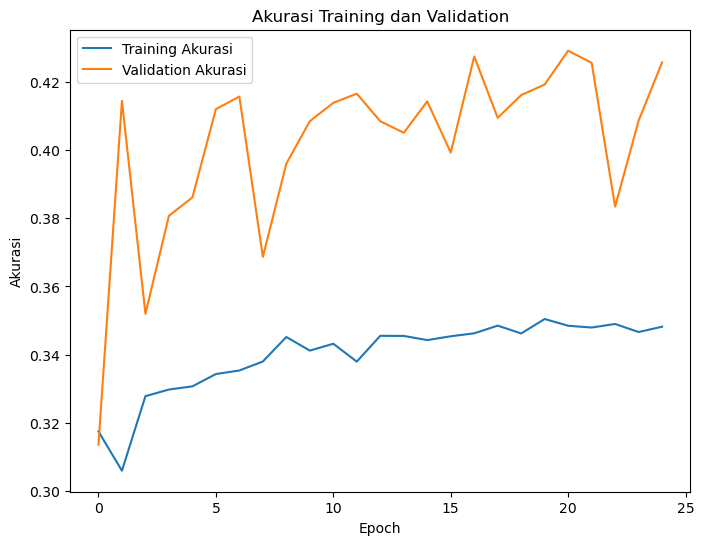

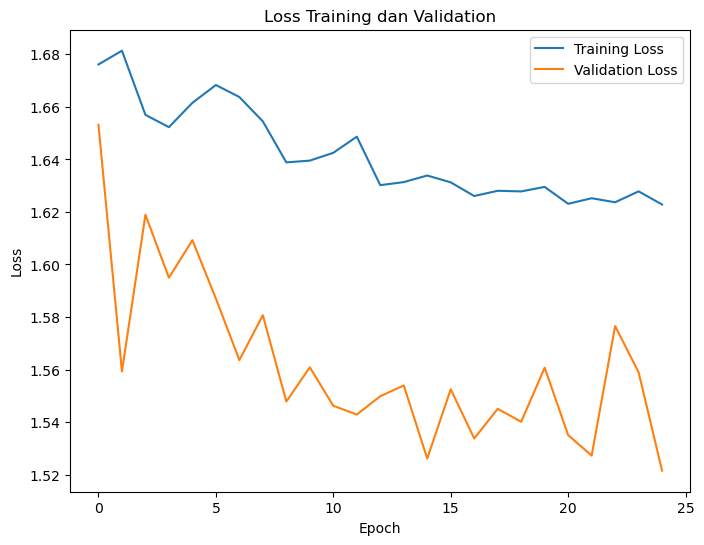

In [9]:
# 5. Visualisasi Skor Epoch

# Plot Akurasi
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Training Akurasi')
plt.plot(valid_accuracies, label='Validation Akurasi')
plt.title('Akurasi Training dan Validation')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Loss Training dan Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Processing image: Anger.jpg


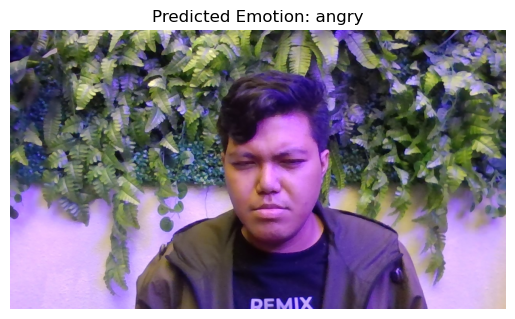

Processing image: Contempt.jpg


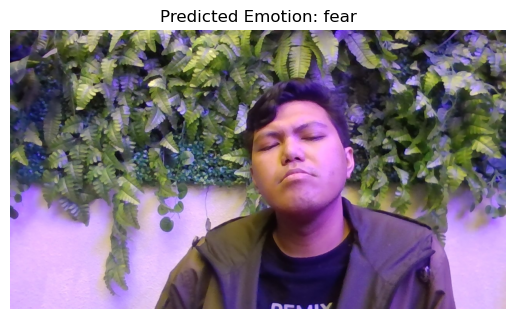

Processing image: Disgust.jpg


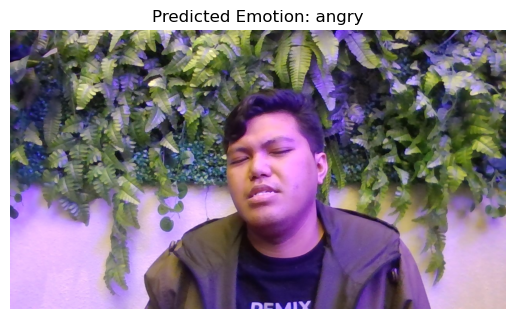

Processing image: Fear.jpg


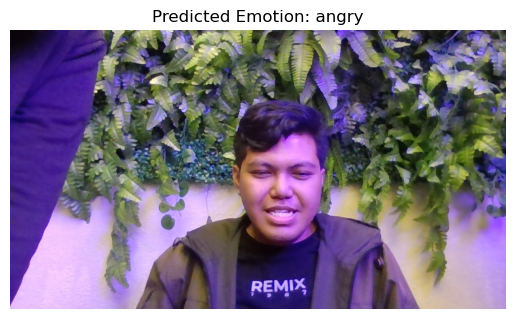

Processing image: Happy.jpg


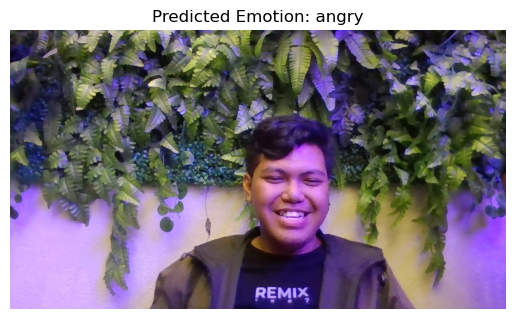

Processing image: Neutral.jpg


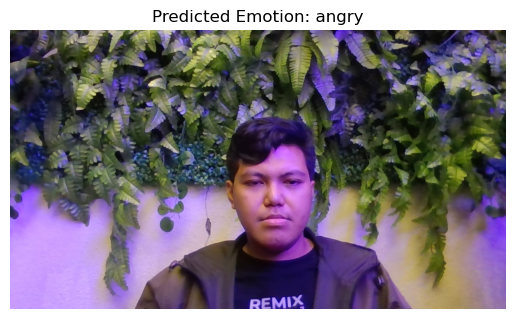

Processing image: Sad.jpg


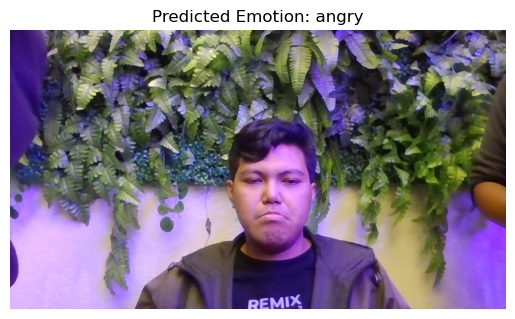

Processing image: Surprised.jpg


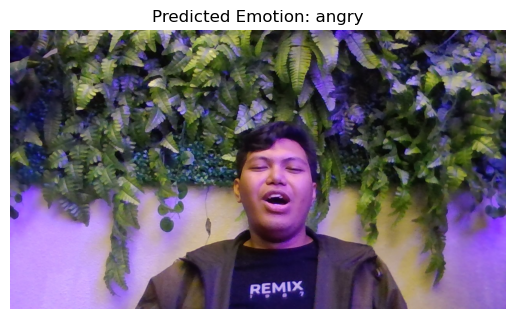

In [10]:
# Fungsi untuk memprediksi ekspresi wajah pada gambar
def predict_image(model, img_path, transform, label_mapping):
    # Memuat gambar dan menerapkan transformasi
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Menambahkan dimensi batch (1, C, H, W)

    # Mengirim gambar ke device (GPU/CPU)
    image = image.to(device)

    # Menggunakan model untuk prediksi
    model.eval()  # Menyetel model ke evaluasi mode
    with torch.no_grad():  # Tidak menghitung gradien untuk prediksi
        outputs = model(image)
        _, preds = torch.max(outputs, 1)  # Mendapatkan label prediksi
        predicted_class = preds.item()

    # Mengembalikan nama label
    predicted_label = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_class)]
    return predicted_label

# Path gambar yang ingin diuji
image_folder_path = './Dataset/22'  # Ganti dengan folder yang berisi gambar yang ingin diuji

# Menyimpan label mapping (sesuai dengan training Anda)
label_mapping = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "sad": 5,
    "surprise": 6
}

# Transformasi gambar
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize gambar
    transforms.ToTensor(),  # Konversi ke Tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalisasi sesuai ImageNet
                         [0.229, 0.224, 0.225])
])

# Menampilkan gambar dan prediksi untuk semua gambar dalam folder setelah training
for img_name in os.listdir(image_folder_path):
    img_path = os.path.join(image_folder_path, img_name)
    
    if img_path.endswith(".jpg") or img_path.endswith(".png"):
        print(f"Processing image: {img_name}")

        # Prediksi untuk gambar
        predicted_label = predict_image(model_resnet, img_path, transform, label_mapping)

        # Menampilkan gambar dan prediksi
        image = Image.open(img_path)
        plt.imshow(image)
        plt.title(f"Predicted Emotion: {predicted_label}")
        plt.axis('off')  # Menyembunyikan axis
        plt.show()